Name: Elizabeth Kuol

Project 9: Los Angeles Crime Data from 2020 to Present (LAPD)

Data Source:
The full dataset is available from Data.gov:  
[Crime Data from 2020 to Present (LAPD)](https://catalog.data.gov/dataset/crime-data-from-2020-to-present)

Note: Due to GitHub's file size limits, the full dataset is not uploaded here. You can download it directly from the link above.


The data I used for this project comes from the LAPD's publicly available dataset on Data.gov, which includes detailed crime reports from 2020 to the present within the city of Los Angeles. The idea to include a KDE heatmap came from a blog post I saw on Towards Data Science while browsing ways to visualize geographic data. I wasn't familiar with this technique at first, so I turned to ChatGPT to better understand what it does, how it works, and how to implement it using sns.kdeplot() in Seaborn. Throughout the coding process, I also used ChatGPT for debugging. One example was when I kept getting NaT values after converting my date columns — ChatGPT helped me realize I needed to include the full timestamp format in the pd.to_datetime() function. Another issue was when my KDE heatmap kept crashing or raising errors about contour levels — ChatGPT explained that the problem was caused by invalid latitude/longitude values (like zeros) in the dataset, and showed me how to filter them out to fix the plot. These tools were extremely helpful in getting my analysis to work correctly.

In [38]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
#Upload the data.
df_crime = pd.read_csv("/content/Crime_Data_from_2020_to_Present.csv")
df_crime.head() #Examine the first few rows

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


In [40]:
df_crime.shape

(1005199, 28)

Data Wrangling

In [41]:
# Drop rows where any of the essential columns are missing: latitude, longitude, date occurred, crime code, or crime description.
# Using .copy() ensures this is a new independent DataFrame and avoids chained assignment issues.
df_crime_cleaned = df_crime.dropna(subset=['LAT', 'LON', 'DATE OCC', 'Crm Cd', 'Crm Cd Desc']).copy()

# Convert the 'DATE OCC' column (date the crime occurred) from string to datetime format. The format is explicitly set to month/day/year to avoid inference errors and speed up parsing.
df_crime_cleaned['DATE OCC'] = pd.to_datetime(df_crime_cleaned['DATE OCC'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')

# Similarly, convert the 'Date Rptd' column (date the crime was reported) to datetime format using the same expected format.
df_crime_cleaned['Date Rptd'] = pd.to_datetime(df_crime_cleaned['Date Rptd'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')

# Create a new column called 'Year' that extracts the year from the 'DATE OCC' colum. This helps with grouping and trend analysis over years.
df_crime_cleaned['Year'] = df_crime_cleaned['DATE OCC'].dt.year

# Create a new column called 'Month' that extracts the month from the 'DATE OCC' column. This is useful for monthly time series analysis and seasonality checks.
df_crime_cleaned['Month'] = df_crime_cleaned['DATE OCC'].dt.month

df_crime_cleaned.head() #examine the first few rows

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Year,Month
0,190326475,2020-03-01,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506,2020,3
1,200106753,2020-02-09,2020-02-08,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628,2020,2
2,200320258,2020-11-11,2020-11-04,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002,2020,11
3,200907217,2023-05-10,2020-03-10,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387,2020,3
4,200412582,2020-09-09,2020-09-09,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130,2020,9


In [42]:
#Shows the number of rows and columns in the cleaned crime data. Note that the columns are now 30 and not 28 because I added two more columns.
df_crime_cleaned.shape

(1005199, 30)

In [43]:
df_crime_cleaned.describe() #This conveys the statistical summary of the data

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON,Year,Month
count,1.005199e+06,1005199,1005199,1.005199e+06,1.005199e+06,1.005199e+06,1.005199e+06,1.005199e+06,1.005199e+06,1.005183e+06,327282.000000,1.005188e+06,69159.000000,2314.000000,64.00000,1.005199e+06,1.005199e+06,1.005199e+06,1.005199e+06
mean,2.202278e+08,2022-05-26 02:56:51.085764608,2022-05-13 22:44:43.764706560,1.339912e+03,1.069097e+01,1.115556e+03,1.400284e+00,5.001459e+02,2.891254e+01,3.056191e+02,363.954782,4.999065e+02,958.103226,984.015990,991.21875,3.399820e+01,-1.180909e+02,2.021879e+03,6.370048e+00
min,8.170000e+02,2020-01-01 00:00:00,2020-01-01 00:00:00,1.000000e+00,1.000000e+00,1.010000e+02,1.000000e+00,1.100000e+02,-4.000000e+00,1.010000e+02,101.000000,1.100000e+02,210.000000,310.000000,821.00000,0.000000e+00,-1.186676e+02,2.020000e+03,1.000000e+00
25%,2.106169e+08,2021-04-21 00:00:00,2021-04-06 00:00:00,9.000000e+02,5.000000e+00,5.870000e+02,1.000000e+00,3.310000e+02,0.000000e+00,1.010000e+02,311.000000,3.310000e+02,998.000000,998.000000,998.00000,3.401470e+01,-1.184305e+02,2.021000e+03,3.000000e+00
50%,2.209160e+08,2022-06-08 00:00:00,2022-05-26 00:00:00,1.420000e+03,1.100000e+01,1.139000e+03,1.000000e+00,4.420000e+02,3.000000e+01,2.030000e+02,400.000000,4.420000e+02,998.000000,998.000000,998.00000,3.405890e+01,-1.183225e+02,2.022000e+03,6.000000e+00
75%,2.311105e+08,2023-07-04 00:00:00,2023-06-22 00:00:00,1.900000e+03,1.600000e+01,1.613000e+03,2.000000e+00,6.260000e+02,4.400000e+01,5.010000e+02,400.000000,6.260000e+02,998.000000,998.000000,998.00000,3.416490e+01,-1.182739e+02,2.023000e+03,9.000000e+00
max,2.521041e+08,2025-04-02 00:00:00,2025-04-01 00:00:00,2.359000e+03,2.100000e+01,2.199000e+03,2.000000e+00,9.560000e+02,1.200000e+02,9.760000e+02,516.000000,9.560000e+02,999.000000,999.000000,999.00000,3.433430e+01,0.000000e+00,2.025000e+03,1.200000e+01
std,1.320295e+07,NaN,NaN,6.510515e+02,6.110387e+00,6.111736e+02,4.899561e-01,2.052633e+02,2.199378e+01,2.193161e+02,123.734904,2.050638e+02,110.354662,52.350982,27.06985,1.610548e+00,5.581809e+00,1.315665e+00,3.463541e+00


Data Analysis

Question 1: What are the top 10 most common crimes in LA since 2020?

Top 10 Most Common Crimes:
 Crm Cd Desc
VEHICLE - STOLEN                                           115246
BATTERY - SIMPLE ASSAULT                                    74848
BURGLARY FROM VEHICLE                                       63518
THEFT OF IDENTITY                                           62539
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     61094
BURGLARY                                                    57879
THEFT PLAIN - PETTY ($950 & UNDER)                          53723
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              53532
INTIMATE PARTNER - SIMPLE ASSAULT                           46712
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             41316
Name: count, dtype: int64


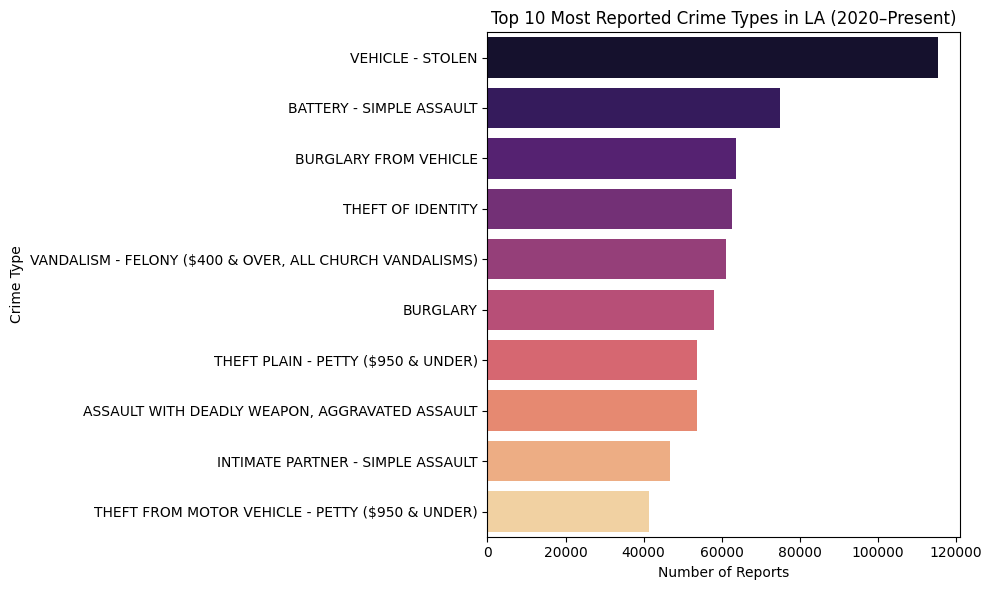

In [44]:
# Count the number of occurrences for each unique crime description,
# sort them in descending order, and select the top 10 most frequent crime types.
top_crimes = df_crime_cleaned['Crm Cd Desc'].value_counts().head(10)
print("Top 10 Most Common Crimes:\n", top_crimes)

#Plot the resulsts
plt.figure(figsize=(10, 6))
sns.barplot(y=top_crimes.index, x=top_crimes.values, hue=top_crimes.index,  palette="magma", legend=False)
plt.title("Top 10 Most Reported Crime Types in LA (2020–Present)")
plt.xlabel("Number of Reports")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()


Interpretation of results:

The bar chart shows the top 10 most reported crimes in Los Angeles from 2020 to the present. Vehicle theft is the most common crime by a large margin, suggesting that car-related incidents are a major issue in the city. Other frequent crimes include battery, burglary from vehicles, and identity theft, which indicates that both physical and property-related offenses are prevalent. Crimes like vandalism, burglary, and petty theft are also high, reflecting ongoing challenges with property security and broadly, economic conditions. The presence of intimate partner assault and aggravated assault raises concerns around personal and domestic violence. Overall, the data shows that LA continues to struggle with a mix of property, violent, and vehicle-related crimes.

Question 2: How do crimes trend in LA over time month-by-month?



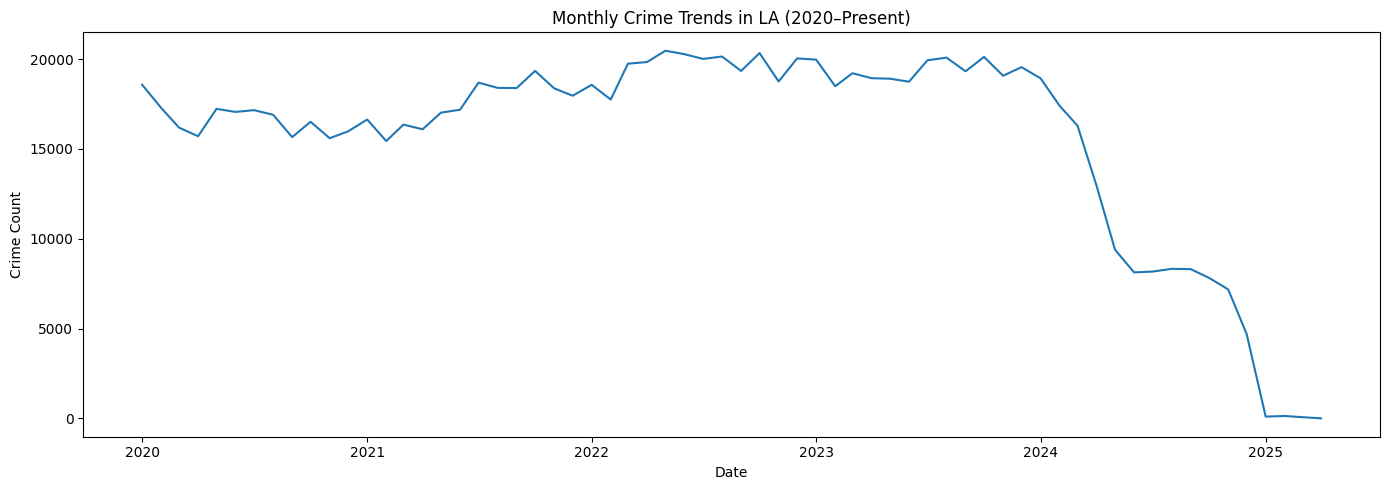

In [45]:
# Group the cleaned dataset by year and month, then count the number of crimes for each month.
# This helps us track how crime fluctuates over time.
monthly_trend = df_crime_cleaned.groupby(['Year', 'Month']).size().reset_index(name='Crime Count')

# Create a proper datetime object by combining the year and month, setting day to 1 for consistency.
# This column will be used for plotting on the x-axis.
monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year', 'Month']].assign(DAY=1))

# Plotting using seaborn's lineplot to visualize how crime counts have changed over time.
plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_trend, x='Date', y='Crime Count')
plt.title("Monthly Crime Trends in LA (2020–Present)")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.tight_layout()
plt.show()

Interpretation of results:

This line plot shows how monthly crime counts in Los Angeles have changed from 2020 to early 2025. Crime levels stayed fairly consistent from 2020 through most of 2023, with some normal ups and downs. However, starting in late 2023, there's a steep and sudden drop in reported crimes, continuing into 2024 and 2025. This sharp decline is likely not due to an actual drop in crime but could be a result of incomplete or missing data for the more recent months or just that crimes did happen but they were not reported. While the data is reliable, especially in the ealier trends,it is important to check whether the dataset was fully updated before drawing any solid conclusions about crime trends after 2023.









Question 3:  Where are the geographic hotspots for crime?

In [46]:
# Round the latitude values to 2 decimal places to group nearby locations together.
# This helps cluster crimes that happen close to each other into the same area.
df_crime_cleaned['lat_rounded'] = df_crime_cleaned['LAT'].round(2)

# Do the same for longitude to group locations more effectively.
df_crime_cleaned['lon_rounded'] = df_crime_cleaned['LON'].round(2)

# Group the data by the rounded lat/lon coordinates and count how many crimes happened in each location cluster.
# This gives us a sense of which areas have the highest concentration of reported crimes.
location_counts = df_crime_cleaned.groupby(['lat_rounded', 'lon_rounded']).size().reset_index(name='Count')

# Sort the location clusters by the number of crimes, from most to least, and take the top 10.
top_locations = location_counts.sort_values(by='Count', ascending=False).head(10)

# Print out the top 10 rounded coordinate locations with the highest crime counts.
print("Top Crime Hotspots:\n", top_locations)

Top Crime Hotspots:
      lat_rounded  lon_rounded  Count
414        34.05      -118.26  13726
415        34.05      -118.25  12980
376        34.04      -118.25   8410
375        34.04      -118.26   7833
589        34.10      -118.33   7767
588        34.10      -118.34   7140
448        34.06      -118.27   6907
447        34.06      -118.28   6019
451        34.06      -118.24   5961
416        34.05      -118.24   5865


Interpretation of results:

This table shows the top 10 areas in Los Angeles with the highest number of reported crimes, grouped by rounded coordinates. For example, the area around latitude 34.05 and longitude -118.26 had over 13,000 reported crimes. While these numbers clearly highlight where crime is concentrated, the coordinates alone aren't very intuitive. If you're not familiar with how to read them, that's totally fair — they roughly point to locations near Downtown LA and surrounding neighborhoods. To make this more useful in practice, we could connect these coordinates to actual neighborhood names or display them on a map, which would make the data more relatable and easier to understand.

New technique (Visualization): KDE Heatmap of Crime Density.

How I learned about KDE Heatmaps

While working on my crime data project, I wanted to find a more interesting way to visualize where crimes were happening most frequently across Los Angeles. I came across a heatmap while browsing a blog post on Towards Data Science, where someone used it to show foot traffic patterns in a city. That sparked my interest because I realized a similar technique could help me highlight crime "hotspots" without having to label every single data point. After seeing it, I used ChatGPT to learn more about what a heatmap actually does and how it works under the hood. That's when I found out about KDE (Kernel Density Estimation) plots using sns.kdeplot() in Seaborn. It turns out that KDE heatmaps are great for showing spatial concentration of data points, which made them a perfect fit for this part of my analysis. I thought it would be a visually effective way to represent the density of crime locations, especially for an audience unfamiliar with raw coordinates. So, I decided to use this as my new technique for the project, and I documented each part of the code and what it does to better understand how it contributes to the overall visualization.



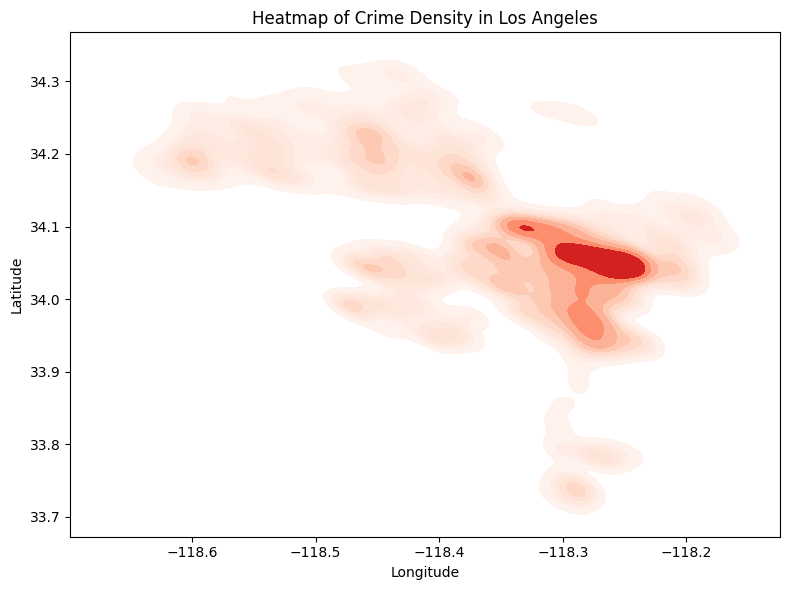

In [52]:
# Filter out rows with zero latitude or longitude
df_crime_cleaned = df_crime_cleaned[(df_crime_cleaned['LAT'] != 0) & (df_crime_cleaned['LON'] != 0)]

# Sample 10,000 random rows to reduce computation time
df_sampled = df_crime_cleaned.sample(n=10000, random_state=1)

# Create a new figure for the plot with a fixed size (8 inches wide by 6 inches tall).
plt.figure(figsize=(8, 6))

# Generate a 2D KDE (kernel density estimate) heatmap to visualize the density of crimes.
# 'x' and 'y' are the longitude and latitude, representing geographic location.
# 'fill=True' makes the plot use solid shading rather than contour lines.
# 'cmap="Reds"' applies a red color scale where darker shades represent higher crime density.
# 'bw_adjust=0.5' adjusts the smoothing bandwidth — lower values make the plot more detailed.
# 'levels=100' increases the number of contour layers for a finer gradient.
# 'thresh=0.05' sets a threshold to hide very low-density areas which allows for clarity and reducing confusion.
sns.kdeplot(data=df_crime_cleaned, x="LON", y="LAT", fill=True, cmap="Reds", bw_adjust=1.0)

# Set the plot title and axis labels.
plt.title("Heatmap of Crime Density in Los Angeles")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Adjust the layout so nothing overlaps or gets cut off.
plt.tight_layout()

# Display the final plot.
plt.show()

Interpretation of resulst:

This heatmap shows where crimes are most densely concentrated across Los Angeles. The darkest red area—near 34.05 latitude and -118.25 longitude—likely represents Downtown LA, which makes sense given how busy and densely populated that area is. Other lighter red areas show where crime is less concentrated but still present. Since the heatmap is based on a sample and uses smoothed data, it highlights general patterns rather than exact locations. One thing to keep in mind is that while this gives a clear overview, it does not really account for things like population size or police reporting practices, which could also affect how crime appears in different areas. Overall, it is a helpful visual to understand where crime tends to cluster in the city.